# 앙상블 학습 개요(Ensemble Learning) 

- 여러 개 분류기(classifier) 생성하고 그 예측을 결합해서 더 적확한 최종 예측 도출하는 기법
- 정형 데이터 분류 시에 앙상블 성능 뛰어남

- 랜덤포레스트와 그래디언트 부스팅 알고리즘 -> XGBoost, LightGBM, 스태킹(Stacking) 

- 학습 유형: 보팅, 배깅, 부스팅, 스태깅
    - 보팅과 배깅: 여러 개 분류기가 투료를 통해 최종 예측 결과 결정
        - 보팅: 서로 다른 알고리즘 가진 분류기 결합
        - 배깅: 같은 유형 알고리즘 분류기 기반. 데이터 샘플링 다르게 가져가면서 학습 수행해 보팅 수행 > 랜던포레스트
            - 부트스트래핑(Bootstrapping): 개별 Classifier 에게 데이터를 샘플링해서 추출하는 방식
            - 중첩 허용
        - 부스팅: 여러 개 분류기가 순차적 학습 수행, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해 올바르게 예측할 수 있도록 다음 분류기에 가중치 부여
            - 그래디언트 부스트, XGBoost, LightGBM 
        - 스태킹: 여러 다른 모델 예측 결괏값을 다시 학습 데이터로 만들어 다른 모델(메타 모델) 로 재학습시켜 결과 예측

## 보팅 유형 - 하드 보팅(Hard Voting)과 소프트 보팅(Soft Voting) 

- 하드 보팅: 다수결 원칙
- 소프트 보팅:분류기들 레이블 값 결정 확률을 모두 더하고 이를 평균해 확률 높은 레이블 값을 최종 보팅 결괏값으로 선정. 일반적 소프트 보팅 


## 보팅 분류기(voting Classifier) 

- 사이킷런 VotingClassifer클래스
- 위스콘신 유방암 데이터 세트 - load_breast_cander() 함수
- 로지스틱 회귀와 KNN 기반 보팅 분류기 만들기 

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


로지스틱 회귀와 KNN 기반으로 하여 소프트 보팅 방식으로 새로운 보팅 분류기 만들기

사이킷런 - VotingClassifier 클래스로 보팅 분류기 생성

    - 주요 생성인자
        - estimator: 리스트 값으로 보팅에 사용될 여러개 Classifier 객체들을 튜플 형식으로 입력 받음
        - voting : 'hard', 'soft' - 기본= 'hard' 

In [2]:
# 개별 모델은 로지스틱 회귀와 KNN 임. 
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

#  개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


- 보팅으로 여러 개 기반 분류기 결합한다고 해서 무조건 기반 분류기 보다 예측 성능이 향상되진 않는다. 
- 전반적으로 앙상블 방법이 전반적 단일 ML알고리즘 보다 뛰어난 성틍 가짐

- ML 모델 성능은 이렇게 다양한 데이터에 의해 검증되므로 어떻게 높은 유연성을 가지고 현실에 대처할 수 있는가가 ML모델 평가요소가 된다.
- 따라서, 편향-분산 트레이드오프는 ML모델이 극복해야 할 중요 과제임

- 보팅과 스태킹등은 서로 다른 알고리즘을 기반으로 하고 있지만, 배깅과 부스팅은 대부분 결정 트리 알고리즘 기반으로 한다. 
- 결정트리 알고리즘 장점은 그대로 취하고 단점(과적합등) 보완하면서 편향-분산 트레이드오프 효과 극대화 할 수 있음


## 랜덤포레스트

- 배깅: 같은 알고리즘 여러 개 분류기 만들어 보팅 
- 빠른 수행속도, 다양한 영역
- 결정트리가 기반
- 여러 개 결증트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습 수행하고 최종적으로 모든 분류기가 보팅 통해 예측 결정
- 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트 = 부트스트래핑
    - bogging = bootstrap aggregating

- 사이킷런 : RandomForestClassifier 클래스
- 사용자 행동인식 데이터 세트 예측
- Random_state = 0    

In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [6]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test        

X_train, X_test, y_train, y_test = get_human_dataset()

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


### 렌덤포레스트 하이퍼 파라미터 튜닝

- 트리 기반 앙상블 알고리즘 단점 
    - 하이퍼 파라미터가 많고, 그로 인해 튜닝을 위한 시간이 많이 소모
    - 많은 시간 후 튜닝 후 예측 성능이 크게 향상되는 경우가 많지 않아 아쉽
    - n_estimators: 결정트리 개수 지정. 디폴트 10. 많이 설정할수록 좋은 성능 기대하지만 계속 증가시킨다고 성능이 무조건 향상 되는 거 아님.
        - 학습 수행시간도 감안
    - max_features: 기본 'auto' = 'sqrt'. 전체 피처 아닌 sqrt(전체피처개수) 만큼 참조.(16개면 4개)
    - max_depth, min_samples_leaf, min_samples_split = 과적합 개선

- GridSearchCV 이용해 랜덤 포레스트 하이퍼 파라미터 튜닝하기
- 사용자 행동 데이터 세트 이용
- 튜닝 시간 절약위해 n_estimator = 100, CV = 2 , n_jobs = -1    

In [8]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [9]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9165


RandomForestClassifier 의 feature_importtances_ 속성 이용 알고리즘이 선택한 피처 중요도 알 수 있음. 

막대그래프 시각확

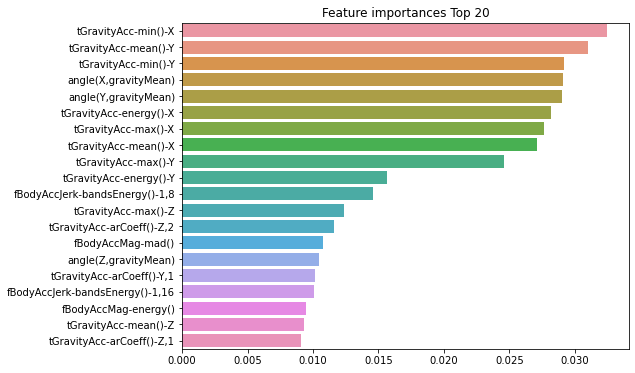

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('rf_feature_importances_top20.tif', format='tif', dpi=300, bbox_inches='tight')

### GBM(Gradient Boosting Machine) 

- 부스팅 알고리즘: 여러 개 약한 학습기 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여 통해 오류 개선해 나가면서 학습하는 방식
- AdaBoost(Adaptive boosting), 그래디언트 부스트
- 에이다부스트: 오류 데이터에 가중치 부여하면서 부스팅 수행
- GBM: 가중치 업데이트를 경사 하강법(Gradient Descent) 이용
    - 경사하강법: 반복 수행을 통해 오류를 최소화 할 수 있도록 가중치 업데이트 값을 도출하는 기법
    - 분류, 회귀 모두 가능
    - 사이킷런: GradientBoostingClassifier 클래스
    - 사용자 행동 데이터 세트 이용
    - 수행시간 체크
    - get_human_dataset() 함수로 데이터 세트 가져오기

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9389
GBM 수행 시간: 1209.7 초 


랜덤 포레스트 보다 예측 성능이 조금 뛰어나지만, 수행 시간이 오래 걸리고, 하이퍼 파라미터 튜닝 노력도 더 필요. 

특히 수행시간 문제는 GBM이 극복해야 할 중요 과제.

#### GBM 하이퍼 파라미터 소개

- n_estimators, max_depth, max_features 외
- loss: 경사 하강법에서 사용할 비용 함수 지정. 기본값 = 'deviance' 
- learning_rate: GBM이 학습 진행할 때마다 적용하는 학습률. weak learner 가 순차적으로 오류 값을 보정해 나가는 데 적용하는 계수.
    - 0 ~ 1 사이 값 지정 가능. 기본값 =  0.1. 
    - 너무 작은 값은 업데이트 되는 값이 작아져 최소 오류 값을 찾아 예측 성능이 높아질 가능성 높음.
    - 하지만, weak learner 는 순차적인 반복이 필요해서 수행 시간이 오래 걸리고, 
    - 너무 작게 설정하면 모든 weak learner 반복이 완료 돼도 최소 오류 값을 찾지 못할 수 있다.
    - 큰 값을 적용하면 최소 오류 값을 찾지 못하고 그냥 지나쳐 버려 예측 성능이 떨어질 가능성이 높아지지만 빠른 수행 가능
    - n_estimators 와 상호 보완적 조합 사용
    - learning_rate 작게하고, n_estimators 크게 하면 더 이상 성능이 좋아지지 않는 한계점까지 예측 성능 좋아질 수 있지만 수행시간 오래걸림.
- n_estimators: weak learner 개수. 개수 많을 수록 일정 수준까지 성능 좋아짐. 개수 많을 수록 수행시간 오래 걸림. 기본값 = 100
- subsample: weak learner 가 학습에 사용하는 데이터 샘플링 비율. 기본값 = 1.(전체 학습 데이터 기반). 0.5면 학습데이터 50%. 
    - 과적합 염려되면 subsample 1보다 작은 값 설정

In [ ]:
### 아래는 책에서 설명드리지는 않지만 GridSearchCV로 GBM의 하이퍼 파라미터 튜닝을 수행하는 예제 입니다. 
### 사이킷런이 1.X로 업그레이드 되며서 GBM의 학습 속도가 현저하게 저하되는 문제가 오히려 발생합니다. 
### 아래는 수행 시간이 오래 걸리므로 참고용으로만 사용하시면 좋을 것 같습니다.

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

In [ ]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

### XGBoost(eXtra Gradient Boost) 

- 트리 기반 앙상블 학습에서 가장 각광받고 있는 알고리즘.
- GBM 기반. 
- 느린 수행 시간, 과적합 규제(Regularization)  부재 등 문제 해결.
    - 뛰어난 예측 성능 - 분류, 회귀에서 뛰어난 성능
    - GBM 대비 빠른 수행시간
    - 과적합 규제로 좀 더 강한 내구성
    - Tree pruning(나무 가지치기):
    - 자체 내장된 교차 검증
    - 결손값 자체 처리

- xgboost 패키지.
- 사이킷런 래퍼 클래스 XGBClassifier, XGBRegressor    

In [12]:
import xgboost as xgb
from xgboost import XGBClassifier

#### 파이썬 래퍼 XGBoost 하이퍼 파라미터

- early stopping, 과적합 규제 파라미터 추가
- 파이썬 래퍼 XGBoost 모듈과 사이킷런 래퍼 XGBoost 모듈 일부 하이퍼 파라미터 약간 다름
    - 사이킷런 파라미터 범용화된 이름 규칙(Namming Rule) 에 따라 파라미터 명이 달라짐

- 파이썬 래퍼 XGBoost 하이퍼 파라미터 유형별로 나누면
    - 일반 파라미터: 일반적 실행시 스레드 개수, silent 모드 등 선택위한 파라미터. 디폴트 파라미터 값을 바꾸는 경우 거의 없음
    - 부스터 파라미터: 트리 최적화, 부스팅, regularization 등과 관련된 파라미터
    - 학습 태스크 파라미터: 학습 수행 시 객체 함수, 평가 위한 지표 등 설정
    - 대부분 부스터 파라미터

    - 주요 일반 파라미터:
        - booster: gbtree 또는 gblinear 선택.  디폴트 = gbtree
        - silent: 디폴트 = 0. 출력 메시지 나타내고 싶지 않을 경우 1로 설정
        - nthread: CPU 실행 스레드 개수 조정. 디폴트 = 전체 스레드 다 사용. 

    - 주요 부스터 파라미터:
        - eta [디폴트= 0.3, alias: learning_rate]: GBM 학습률 같은 파라미터. 0 ~ 1사이 값 지정. 
            - 부스팅 스텝 반복적 수행할 때 업데이트 되는 학습률 값. 파이썬 래퍼 기반 xgboost 이용할 경우 디폴트 = 0.3.
            - 사이킷런 래프 클래스 이용할 경우 eta 는 learning_rate 파라미터 대체. 디폴트 = 0.1. 
            - 보통 0.01 ~ 0.2  사이값 선호

        - num_boost_rounds : GBM의 n_estimators 와 같은 파라미터
        - min_child_weight[디폴트 = 1]: 트리에서 추가적ㅇ로  가지 나눌지 결정하기 위해 필요한 데이터들의 weight 총합. 클수록 분할 자제. 과적합 조절 용
        - gamma [디폴트=0, alias: min_split_loss] : 트리 리프 노드 추가적 나눌지 결정할 최소 손실 감소 값. 
            - 해당값보다 큰 손실이 감소된 경우 리프 노드 분리. 값이 클수록 과적합 감소
        - max_depth[디폴트 = 6]: 트리 기반 알고리즘 max_depth 와 같음.
            - 0을 지정하면 깊이에 제한이 없음. 
            - 높으면 특정 피처 조건에 특화되어 룰 조건이 만들어져 과적합 가능성 높아짐
            - 3 ~ 10 사이 값 적용
        - sub_sample[디폴트 = 1]: GBM subsample 과 동일. 트리가 커져서 과적합 되는 것 제어
            - 0.5 지정하면 전체 데이터 절반 트리 생성 사용
            - 0 ~ 1 사이 값 가능. 일반적으로 0.5 ~ 1 값 사용
        - colsample_bytree[디폴트 = 1]: GBM의 max_features 와 유사. 트리 생성에 필요한 피처(컬럼)를 임의의 샘플림 하는데 사용. 
            - 매우 많은 미처가 있는 경우 과적합 조정하는데 적용
        - lambda [디폴트 = 1, alias: reg_lambda] : L2 Regularization 적용 값. 피처 개수가 많을 경우 적용 검토하여 값이 클수록 과적합 감소효과
        - alpha [디폴트 = 0, alias: reg_alpha] : L1 Regularization 적용 값. 피처 개수 많을 경우 적용을 검토해 값이 클수록 과적합 감소 효과
        - scale_pos_weighg[디폴트 = 1] : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터

    - 학습 태스크 파라미터:
        - objective: 최솟값을 가져야 할 손실 함수를 정의. XGBoost 많은 유형 손실함수 사용 가능. 주료 사용 손실함수는 이진 분류인지 다중 분류인지 따라 달라짐
        - binary:logistic: 이진 분류 적용
        - multi:sofgmax: 다중 분류. 손실함수가 multi:softmax 경우 레이블 클래스의 개수인 num_class 파라미터 지정
        - multi:softprob: multi:softmax 와 유사. 개별 레이블 클래스의 해당되는 예측 확률 반환
        - eval_metric: 검증에 사용되는 함수 정의. 기본값은 회귀 = rmse, 분류 = error 
            - rmse: Root Mean Square Error
            - mae: Mean Absolute Error
            - logloss: Negative log-likeligood
            - error: Binary classification error rate(0.5 threshold) 
            - merror: Multiclass classification error rate
            - mlogloss: Multiclass logloss
            - auc: Area under the curve

    - 과적합 문제가 심각하다면 다음과 같이 적용할 것 고려
        - eta 값 낮추기 (0.01 ~ 0.1) : eta 값 낮추면 num_round(또는 n_estimators) 는 반대로 높여줘야 함
        - max_depth 값 낮추기
        - min_child_weight  값 높이기
        - gamma 값 높이기
        - subsample, colsample_bytree 조정하는 것도 트리가 너무 복잡하게 생성되는 것 막아 과적합 문제 도움

    - XGBoost 는 자체적으로 교차 검증, 성능평가, 피처 중요도 시각화 기능 가짐
    - 수행속도 향상 위한 Early stopping            


In [13]:
import xgboost
print(xgboost.__version__) 

1.5.0


파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측 

- xgboost 모듈 로딩
- 피처 중요도 시각화해주는 모듈인 plot_importance 이용 피처 중요도 시각화
- 사이킷런 내장 데이터 loat_breast_cancer() 호출

In [14]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [15]:
# 레이블 값 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


- 데이터 세트 80% 학습용. 20%를 테스트용 추출한 뒤 
    - 80% 학습용데이터 에서 90%를 최종 학습용, 10%를 검증용 분할
    - 검증용 데이터 세트 별도 분할 이유: XGBoost 가 제공하는 기능인 검증 성능 평가와 조기 중단을 수행하기 위함
- cancer_df 맨 마지막 컬럼이 레이블.
- 피처용 DataFrame 은 cancer_df 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지 :-1 슬라이싱 추출

In [16]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )
print(X_train.shape , X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


파이썬 래퍼 XGBoost는 사이킷런과 여러 차지.

    - XGBoost 만의 전용 데이터 객체인 DMatrix 사용
    - 따라서, Numpy 또는 Pandas 되어 있는 학습용, 검증, 테스트용 데이터 세트를 모두 전용의 데이터 객체인 DMatrix 생성해 모델에 입력해 줘야 함
    - DMatrix 주요 입력 파라미터 : data = 피처데이터세트, label = 분류(레이블 데이터 세트), 회귀(숫자형 종속값 데이터 세트) 

DataFrame 기반 학습데이터세트와 테스트 데이터 세트를 DMatrix 로 변환    

In [17]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환.
# 학습, 검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

학습 수행 전, XGBoost 하이퍼 파라미터 설정. 주로 딕셔너리 형태로 입력.

- max_depth(트리 최대 깊이) = 3
- 학습률 eta = 0.1(XGBClassifier 사용할 경우 eta 아닌 learning_rate) 
- 예제 데이터가 0, 1 이진 분류 이므로 목적함수(objective) = 이진 로지스틱(binary:logistic) 
- 오류 함수 평가 성능지표 = logloss
- num_rounds(부스팅 반복 횟수) = 400회

In [18]:
params = { 'max_depth':3,
          'eta': 0.05,
          'objective':'binary:logistic',
          'eval_metric':'logloss'
         }
num_rounds = 400

- 하이퍼 파라미터를 xgboost 모듈의 train() 함수에 파라미터로 전달
    - 사이킷런의 경우 Estimator 생성자를 하이퍼 파라미터로 전달하는 데 반해 차이가 있음
- 조기 중단 기능: 더 이상 지표 개선 없으면 num_boost_round 회수 모두 채우지 않고 중간에 반복 빠져 나옴
    - 조기 중단 성능 평가는 주로 별도 검증 데이터 세트 이용.
    - XGBoost 는 학습 반복 시마다 검증 데이터 세트 이용해 성능을 평가할 수 있는 기능 제공
    - 조기 중단은 xgboost train() 함수에 early_stopping_rounds 파라미터 입력해 설정.
    - 조기 중단 최소 반복횟수 = 50
    - early_stopping_rounds 파라미터 설정 조기 중단 수행하려면 반드시 평가용 데이터 세트 지정과 eval_metric 함께 설정해야 함
    - Xgboost 는 반복마다 지정된 평가용 데이터 세트에서 eval_metric 의 지정된 평가 지표로 예측 오류 측정

- 평가용 데이터 세트는 학습과 평가용 데이터 세트를 명기하는 개별 튜플을 가지는 리스트 형태로 설정.
    - dtr이 학습용, dval이 평가용 = [(dtr, 'train'), (dval, 'eval')] 
    - eval_metric 은 평가 세트에 적용할 성능평가 방법. 분류 = 'error'(분류오류), 'logloss' 적용

- xgboost 모듈 tranin() 함수 호출하면 학습 수행.
- 평가용 데이터 세트 설정은 [(dtr, 'train'), (dval, 'eval')] 같이 학습용 DMatrix 인 dtr 과 검증용 DMatrix 인 dval 로 설정하고 train() 함수 evals 인자값 입력

In [19]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다. 
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방. 

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds , \
                      early_stopping_rounds=50, evals=eval_list )

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52929
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31893	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

- 테스트 데이터 세트에 예측 수행.
- 사이킷런 perdict()메서드는 예측 결과 클래스 값을 반환하는데 xgboost predict() 는 예측 결괏값 아닌 예측 결과 추정할 수 있는 확률 값 반환

In [20]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


get_clf_eval() 함수 적용해 XGBoost 모델 예측 성능 평가

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [22]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


- xgboost 패키지 내장된 시각화 기능 수행
- plot_importance() API = 피처 중요도 막대그래프 형식으로 나타냄. 
- 기본 평가 지표: f-score 기반 해당 피처 중요도 나타냄.
    - f스코어: 해당 피처가 트리 분할 시 얼마나 자주 사용되었는지 지표로 나타낸 값
- 사이킷런 Estimator 객체 feature_importances_ 속성 이용해 직접 시각화 코드 작성. 
- xgboost 패키지는 plot_importance() 이용해 바로 피처 중요도 시각화 가능
    - plot_importance() 호출 시 파라미터로 앞에서 학습된 모델 객체 및 맷플롯립의 ax 객체 입력
    - 유의점: xgboost 를 DataFrame 아닌 넘파이 기반 피처 데이터로 학습 시에는 넘파이에서 피처명을 제대로 알 수 없어 Y축의 피처명을 나열 시 f0, f1 로 나타매

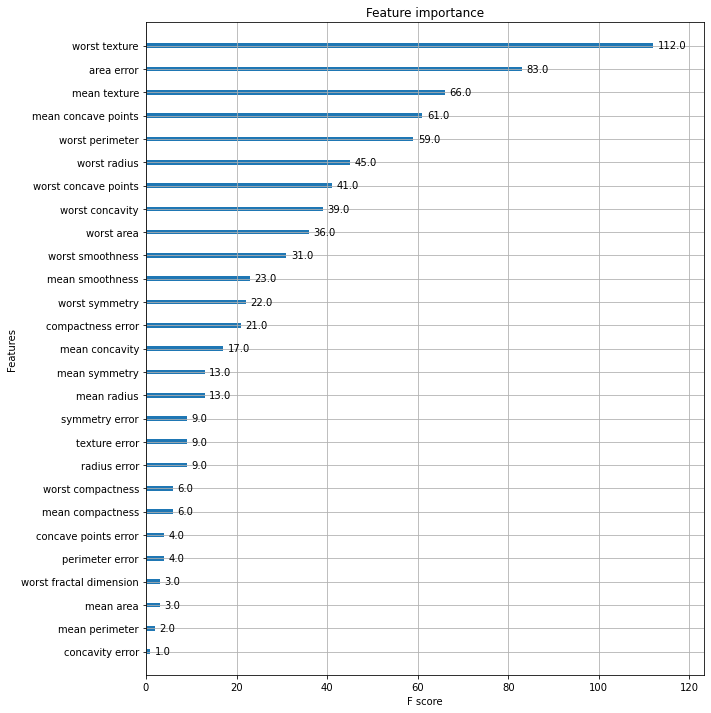

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.savefig('p239_xgb_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

- 파이썬래퍼 XGBoost는 사이킷런 GridSearchCV 와 유사하게 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터 구할 수 있는 방법을 cv() API로 제공
- xgboost.cv 파라미터
    - params (dict): 부스터 파라미터
    - dtrain(DMatix): 학습 데이터
    - num_boost_round (int): 부스팅 반복 횟수
    - nfold (int): CV 폴드 개수
    - stratified (bool): CV 수행 시 층화 표본 추출(stratified sampling) 수행 여부
    - metrics (string or list of string) : CV 수행 시 모니터링할 성능 평가 지표
    - early_stopping_rounds (int): 조기 중단 활성화시킴. 반복 횟수 지정.
- xgb.cv 반환값은 DataFrame . 

### 사이킷런 래퍼 XGBoost 의 개요 및 적용 

- 사이킷런 기본 Estimator 그대로 상속해 Estimator 와 동일하게 fit() predict() 만으로 학습 예측 가능하고 GridSearchCV, Pipeline 등 사이킷런 유틸리티 사용
- XGBClassifier(분류), XGBRegressor(회귀) 
- 파라미터
    - eta -> learning_rate
    - sub_sample -> subsample
    - lambda -> reg_lambda
    - alpha -> reg_alpha
    - n_estimators 만 적용

- 위스콘신 유방암 데이터 예측
- n_estimators = 400
- learning_rate = 0.1, max_depth = 3    

In [24]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[13:24:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


사이킷런 래퍼 XGBoost 에서 조기 중단 수행

- 조기중단 관련 파라미터를 fit()에 입력
- 조기 중단 파라미터: early_stopping_rounds(평가 지표 향상될 수 있는 반복 횟수 정의), early_metric(조기중단 윈한 평가 지표), eval_set(성능 평가 수행 데이터세트)
- 최종 학습 데이터에서 다시 분리된 최종 학습 데이터와 검증데이터 이용
- early_stopping_rounds 100, eval_metric = logloss, eval_set = 

In [26]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

조기 중단 학습된 XGBClassifier 예측 성능 

In [27]:
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


조기 중단 값을 너무 급겹하게 줄이면 예측 성능이 저하될 우려 큼.

만일, early_stopping_rounds 10으로 하면 아직 성능이 향상될 여지가 있어도 10번 반복하는 동안 성능 평가지표 향상 안되면 반복 멈춰서 충분한 학습 안되고 예측 성능이 나빠 질 수 있음.

early_stopping_rounds 10 설정

In [28]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

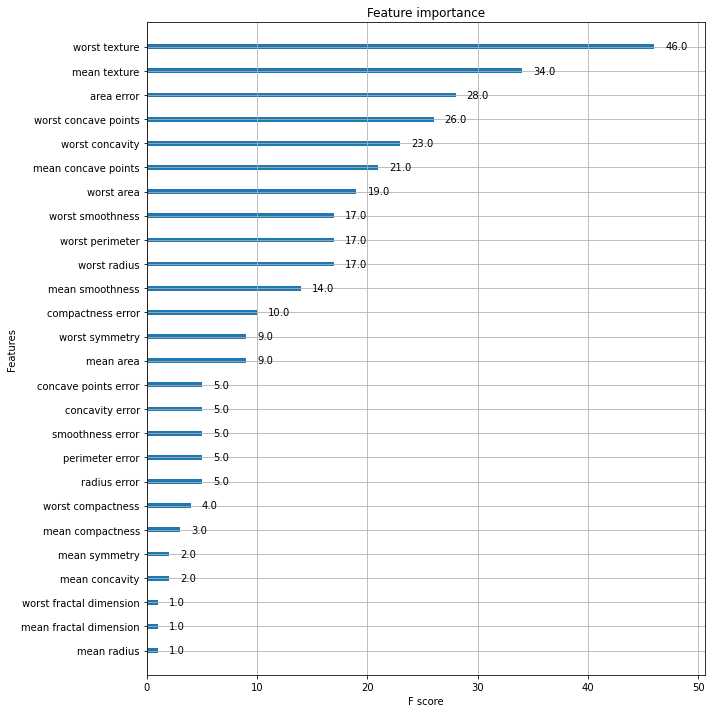

In [29]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

### Light GBM

- 부스팅 계열 알고리즘에서 가장 각광
- Xgboost는 여전히 학습 시간 오래 걸림
- XGBoost 보다 학습에 걸리는 시간이 훨씬 적고 메모리 사용량 상대적으로 적음
- 과적합 문제? 10000건 이하 데이터에서

- 리프 중신 트리 분할(Leaf Wise) 방식 사용 <-> 기존은 균형 트리 분할 사용
    - 트리 균형 맞추지 않고 최대 솔실 값( max delta loss) 가지는 리프 노드 지속 분할
- 카테고리형 피처의 자동 변환과 최적 분할

- 사이킷런 래퍼 LightGBM 클래스는 분류(LGBMClassfier) / 회귀(LGBMRegressor) 클래스 
    - 사이킷런 기반 Estimator 상속 받아 작성됐기 때문에  fit(), predict() 기반 학습 및 예측 사이킷런 제공하는 다양한 유틸리티 활용 가능

#### LightGBM 하이퍼 파라미터

- num_iterations[디폴트 = 100] : 반복 수행하려는 트리 개수. 클수록 예측 성능 높아질 수 있으나, 너무 크게 지정하면 오히려 과적합. 
    - n_estimators 와 같은 파라미터 n_estimators 
- learning_rate[디폴트 = 0.1] : 0 ~ 1 사이 값 지정하여  부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값. 
    - n_estimators 를 크게 하고 learning_rate 값 작게 해서 예측 성능 향상 시킬 수 있으나 과적합 이슈및 학습 시간 길어짐.
- max_depth[디폴트 = -1]: 0 보다 작은 값 지정하면 제한 없음. 깊이가 상대적으로 더 깊다
- min_deta_in_leaf[디폴트 = 20]: min_child_samples 파라미터. 과적합 제어
- num_leaves[디폴트 = 31]: 하나의 트리가 가질 수 있는 최대 리프 개수
- boosting [디폴트 = gbdt] : 부스팅의 트리를 생성하는 알고리즘 기술
    - gbdt : 일반적인 그래디언트 부스팅 결정 트리
    - rf: 랜덤 포레스트 
- bagging_fraction[디폴트 = 1.0]: 트리가 커져서 과적합 되는 것 제어. 데이터 샘플링하는 비율 지정. subsample 파라미터와 동일. 
- feature_fraction[디폴트 = 1.0]: 개별 트리 학습할 때마다 무작위로 선택하는 피처 비율. 과적합 방지. max_feature 와 비슷. colsample_bytree와 같음. 
- lambda_l2[디폴트 = 0.0]: L2 regulation 제어위한 값. 피처 개수 많을 수록 적용 검토. 값이 클수록 과적합 감소효과. reg_lambda동일.
- lambda_l1[디폴트 = 0.0]: L1 regulation 제어 위함 값. 과적합 제어. reg_alpha 동일.

* Learning Task 파라미터
- objective: 최솟값 가져야 할 손실함수 정의. 회귀, 다중 클래스 분류, 이진 분류인지에 따라 objective 손실함수 지정



* 하이퍼 파라미터 튜닝 방안

- num_leaves 개수 중심으로 min_child_sample(min_data_in_leaf), max_depth 함께 조정하면서 모델 복잡도 줄이는 것이 기본.

- num_leaves 는 개별 트리가 가질 수 있는 최대 리프 개수이고 LightGBM 모델 복잡도를 제어하는 주요 파라미터임. 일반적으로 num_leaves개수 높이면 정확도 높아짐.
    - 반대로 트리 깊이 깊어지고 모델 복잡도 커져 과적합 영향도 커짐

- min_data_in_leaf: 사이킷런 래퍼 클래스 에서 min_child_samples 로 이름 바뀜. 과적합 개선하기 위한 중요한 파라미터. num_leaves와 학습 데이터 크기에 따라 다름. 
    - 보통 큰 값으로 설정하면 트리가 깊어지는 것 방지

- max_depth: 명시적으로 깊이 크기 제한. num_leaves, min_data_in_leaf 와 결합해 과적합 개선하는 데 사용

- learning_rate 작게 하면서 n_estimators 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안
    - n_estimators 너무 크게 하면 과적합 

- 과적합 제어위해: reg_lambda, reg_alpha 같은 regularization 적용하거나 
- 학습 데이터에 사용할 피처 개수나  데이터 샘플링 레코드 개수 술이기 위해 colsample_bytree, subsample 파라미터 적용 

* LigntGBM 적용 - 위스콘신 유방암 예측 

- lightgbm LGBMClassifier 임포트 
- 조기 중단 가능 fit() 
- n_estimators  = 400, early_stopping_rounds = 50 

In [30]:
import lightgbm

print(lightgbm.__version__)

3.2.1


In [32]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
Training until validation scores don't improve for 50 rounds
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [34]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


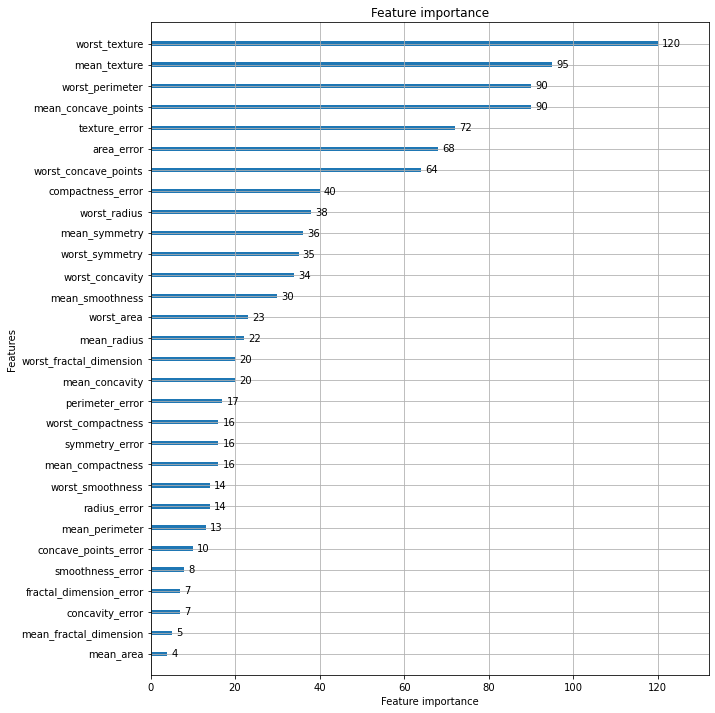

In [35]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')